In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import to_categorical


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [10]:
#setamos o seed para reprodução do experimento
np.random.seed(2)

In [11]:
df_train = pd.read_csv('../input/digit-recognizer/train.csv')
df_test = pd.read_csv('../input/digit-recognizer/test.csv')

In [12]:
#retiramos a informação do digito
x_train = df_train.drop(["label"], axis=1).values

#apesar do dataset ja estar no formato 28x28, o framework do keras espera que seja
#informado a terceira dimensão,portanto já redimensionamentos para 28x28x1.
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = df_test.values.reshape((df_test.shape[0], 28, 28, 1))

In [13]:
# utilizamos a função to_categorial do utils do keras para fazermos o one-hot-encoder da classe.
y_train = df_train["label"].values
y_train = to_categorical(y_train)

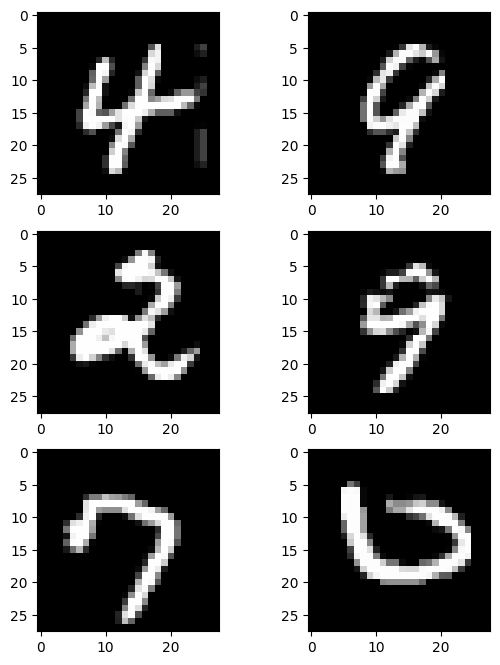

In [14]:
#visualizando randomicamente algumas imagens
for i in range(0, 6):
    random_num = np.random.randint(0, len(x_train))
    img = x_train[random_num]
    plt.subplot(3,2,i+1)
    plt.imshow(img.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.subplots_adjust(top=1.4)
plt.show()

In [15]:
## dado que o range de valores possível pra um pixél vai de 0-255 
## escalonamos os valores entre 0-1
## esse processo torna nosso modelo menos variante a pequenas alterações.
x_train = x_train / 255
x_test = x_test / 255

In [16]:
model = Sequential()
model.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(28, 28,1)))
model.add(Conv2D(64, (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [17]:
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1605760   
                                                      

In [18]:
# reduz o parâmetro de learning rate se não houver 
# melhoras em determinado número de epocas
# útil para encontrar o mínimo global.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
batch_size = 32
epochs = 10

In [20]:
history = model.fit(x_train,
                        y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_split=0.2,
                        verbose = 1,
                        callbacks=[learning_rate_reduction])

Epoch 1/10
1050/1050 [==============================] - 131s 123ms/step - loss: 0.2148 - accuracy: 0.9338 - val_loss: 0.0543 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 2/10
1050/1050 [==============================] - 128s 122ms/step - loss: 0.0866 - accuracy: 0.9754 - val_loss: 0.0486 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 3/10
1050/1050 [==============================] - 131s 125ms/step - loss: 0.0592 - accuracy: 0.9828 - val_loss: 0.0400 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 4/10
1050/1050 [==============================] - 129s 123ms/step - loss: 0.0488 - accuracy: 0.9845 - val_loss: 0.0367 - val_accuracy: 0.9899 - lr: 0.0010
Epoch 5/10
1050/1050 [==============================] - 129s 123ms/step - loss: 0.0415 - accuracy: 0.9869 - val_loss: 0.0374 - val_accuracy: 0.9896 - lr: 0.0010
Epoch 6/10
1050/1050 [==============================] - 131s 124ms/step - loss: 0.0363 - accuracy: 0.9893 - val_loss: 0.0399 - val_accuracy: 0.9894 - lr: 0.0010
Epoch 7/10
1050/1050 [============

In [24]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
range_epochs = range(1, len(acc) + 1)

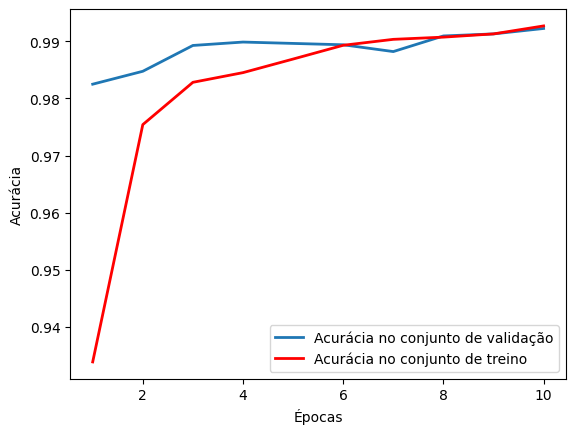

In [25]:
plt.style.use('default')
accuracy_val = plt.plot(range_epochs, val_acc, label='Acurácia no conjunto de validação')
accuracy_train = plt.plot(range_epochs, acc, label='Acurácia no conjunto de treino', color="r")
plt.setp(accuracy_val, linewidth=2.0)
plt.setp(accuracy_train, linewidth=2.0)
plt.xlabel('Épocas') 
plt.ylabel('Acurácia')
plt.legend(loc="lower right")
plt.show()

## **Agora iremos visualizar algumas predições**

In [27]:
predictions = np.argmax(model.predict(x_test), axis=-1)

875/875 [==============================] - 28s 32ms/step


array([2, 0, 9, ..., 3, 9, 2])

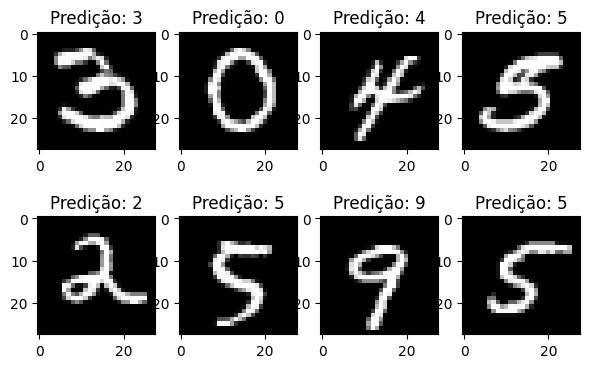

In [28]:
plt.figure(figsize=(7,14))
for i in range(0, 8):
    random_num = np.random.randint(0, len(x_test))
    img = x_test[random_num]
    plt.subplot(6,4,i+1)
    plt.margins(x = 20, y = 20)
    plt.title('Predição: ' + str(predictions[random_num]))
    plt.imshow(img.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

In [35]:
submission = pd.DataFrame({'ImageID' : pd.Series(range(1,28001)), 'Label' : predictions})
submission.to_csv("submission.csv",index=False)